In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

independent = True

In [2]:
data_dir = "/root/data/norm_fog_data/"
# data_dir = 'drive/MyDrive/599_project_data/norm_fog_data/'

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

# Load the data

In [3]:
WINDOW_SIZE = 650
WINDOW_STEP = 200

train_X = []
train_Y = []
test_X = []
test_Y = []

all_X = []
all_Y = []


for file in data_files:
    print(file)
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]
    y[y<0] = 0
    y[y>0] = 1
    print(y.sum())
    # Remove both waist and right shank columns since test data is missing there
    #channels_to_remove = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]  # These are channel inds AFTER removing timestamp and labels
    #x = np.delete(x, channels_to_remove, axis=1)


    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = y.size // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    x = x[:end, :]  # (n_samples, d)
    y = y[:end]

    # Reshape into (n_windows, window_size, d)
    #x = x.reshape(n_windows, WINDOW_SIZE, -1)
    #y = y.reshape(n_windows, WINDOW_SIZE)
    # Split into overlapping windows
    x = np.lib.stride_tricks.sliding_window_view(x, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    y = np.lib.stride_tricks.sliding_window_view(y, WINDOW_SIZE, axis=0)[::WINDOW_STEP]

    x = x.transpose(0,2,1)
    
    if independent:
        if patient_num in ('001', '009', '010'):
            test_X.append(x)
            test_Y.append(y)
        else:
            train_X.append(x)
            train_Y.append(y)
    else:
        all_X.append(x)
        all_Y.append(y)


/root/data/norm_fog_data/008_task_1.csv
102500.0
/root/data/norm_fog_data/004_task_1.csv
0.0
/root/data/norm_fog_data/006_task_3.csv
17000.0
/root/data/norm_fog_data/001_task_4.csv
0.0
/root/data/norm_fog_data/001_task_1.csv
65500.0
/root/data/norm_fog_data/008_task_9.csv
10000.0
/root/data/norm_fog_data/010_task_1.csv
195500.0
/root/data/norm_fog_data/002_task_4.csv
1500.0
/root/data/norm_fog_data/005_task_1.csv
0.0
/root/data/norm_fog_data/004_task_4.csv
2500.0
/root/data/norm_fog_data/008_task_7.csv
92000.0
/root/data/norm_fog_data/011_task_1.csv
127500.0
/root/data/norm_fog_data/004_task_3.csv
0.0
/root/data/norm_fog_data/009_task_2.csv
14000.0
/root/data/norm_fog_data/008_task_4.csv
2500.0
/root/data/norm_fog_data/007_task_3.csv
16000.0
/root/data/norm_fog_data/003_task_4.csv
26500.0
/root/data/norm_fog_data/010_task_3.csv
15000.0
/root/data/norm_fog_data/009_task_3.csv
25500.0
/root/data/norm_fog_data/011_task_3.csv
20500.0
/root/data/norm_fog_data/006_task_1.csv
67000.0
/root/da

In [4]:
if independent:
    train_X = np.concatenate(train_X, axis=0)
    train_Y = np.concatenate(train_Y, axis=0)

    test_X = np.concatenate(test_X, axis=0)
    test_Y = np.concatenate(test_Y, axis=0)
else:
    all_X = np.concatenate(all_X, axis=0)
    all_Y = np.concatenate(all_Y, axis=0)
    
    test_X = all_X[22994:]
    train_X = all_X[:22994]
    test_Y = all_Y[22994:]
    train_Y = all_Y[:22994]



# Example of augmentation applied

In [5]:
train_X.shape

(22994, 650, 30)

In [6]:
train_X.shape

(22994, 650, 30)

In [7]:
y = train_X[0, :, 0]

In [8]:
y_stretch = signal.resample(y, int(len(y) * 1.1))
y_squeeze = signal.resample(y, int(len(y) * 0.9))
y_shrink = y * 0.8
y_scaled = y * 1.2

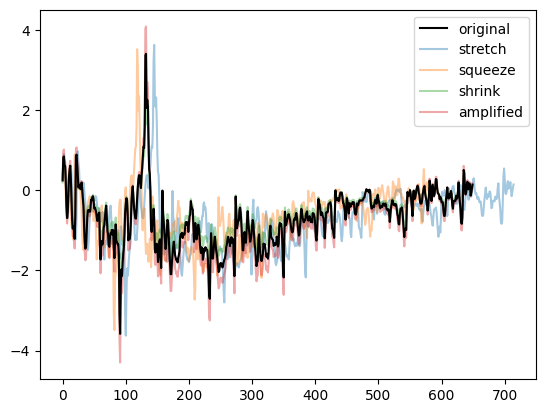

In [9]:
plt.plot(y, label="original", zorder=4, c='k')
plt.plot(y_stretch, label="stretch", alpha=0.4)
plt.plot(y_squeeze, label="squeeze", alpha=0.4)
plt.plot(y_shrink, label="shrink", alpha=0.4)
plt.plot(y_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [10]:
# Build dataset, dataloader, collate function

In [11]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class FoGDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=512, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [12]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

augment_fn = FoGDataAugment(out_samples=512)
test_augment = FoGDataAugment(out_samples=512, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

In [13]:
del train_X, train_Y, test_X, test_Y, train_dataset, test_dataset

# Define model

In [14]:
class TransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        self.input_transform = nn.Linear(in_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.input_transform(x)
        x = self.encoder(x)
        x = self.layer_norm(x)

        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirectional):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x)
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return out

In [16]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirection):
        super(CNNLSTMModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=30, out_channels=64, kernel_size=4)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64,out_channels=32,kernel_size=4)


          # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc1 = nn.Linear(fc_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
       
        out = self.conv1(x.transpose(1,2))
        out = self.mp(out)
        #out = self.conv2(out)
        #out = self.mp(out)
        
        #out = self.conv2(out)
        #out = self.mp(out)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(out.transpose(1,2))
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc1(out.flatten(start_dim=-2))
        out = self.fc2(out)
        #out = self.fc3(out)

        return out

In [17]:
class CNNLSTM(nn.Module):
    def __init__(self, input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', input_dim=1, hidden_dim=1, layer_dim=1, output_dim=1, fc_dim=1, bidirection=True):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=32, stride=2)
        self.mp = nn.MaxPool1d(mp, stride=mp)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=16)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=8)

        #self.conv4 = nn.Conv1d(128, 1, kernel_size=4)
        self.conv4 = nn.Conv1d(128, 1, kernel_size=4)
        self.dropout = nn.Dropout(dropout_prob)

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        if bidirection:
            fc_dim = 2*hidden_dim
        else:
            fc_dim = hidden_dim

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)


    def forward(self, x):
        x = self.conv1(x.transpose(1,2))
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)
        #print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(x)
        
        x = self.conv4(x)
        
        
        x = self.dropout(x)
        #x = x.transpose(1,2)
        x, _ = self.lstm(x)
        
        x = self.fc(torch.flatten(x,1))
        return x

# Training

In [18]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        # if i % logging_steps == 0:
        #     print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [19]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt

def test_model(model, dataloader, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    accuracies = []
    macro_averaged_precisions = []
    micro_averaged_precisions = []
    macro_averaged_recalls = []
    micro_averaged_recalls = []
    macro_averaged_f1s = []
    micro_averaged_f1s = []
    cms = []

    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs).flatten()
            out = torch.round(torch.sigmoid(outputs))
            y = targets
            # y = y.mean(axis=1)
            # y = np.round_(y)
            
            y = torch.tensor(y, dtype=torch.int64)
            accuracy = metrics.accuracy_score(y, out)
            #print('Acc')
            macro_averaged_precision = metrics.precision_score(y, out, average = 'macro')
            micro_averaged_precision = metrics.precision_score(y, out, average = 'micro')
            #print('Precision')
            macro_averaged_recall = metrics.recall_score(y, out, average = 'macro')
            micro_averaged_recall = metrics.recall_score(y, out, average = 'micro')
            #print('Recall')
            macro_averaged_f1 = metrics.f1_score(y, out, average = 'macro')
            micro_averaged_f1 = metrics.f1_score(y, out, average = 'micro')
            # Sitting, standing, walking, upstairs
            cm = confusion_matrix(y, out, labels=[0,1])

            accuracies.append(accuracy)
            macro_averaged_precisions.append(macro_averaged_precision)
            micro_averaged_precisions.append(micro_averaged_precision)
            macro_averaged_recalls.append(macro_averaged_recall)
            micro_averaged_recalls.append(micro_averaged_recall)
            macro_averaged_f1s.append( macro_averaged_f1)
            micro_averaged_f1s.append(micro_averaged_f1)
            cms.append(cm)

    accuracy = np.mean(np.array(accuracies), axis=0)
    macro_averaged_precision = np.mean(np.array(macro_averaged_precisions))
    micro_averaged_precision = np.mean(np.array(micro_averaged_precisions))
    macro_averaged_recall = np.mean(np.array(macro_averaged_recalls))
    micro_averaged_recall = np.mean(np.array(micro_averaged_recalls))
    macro_averaged_f1 = np.mean(np.array(macro_averaged_f1s))
    micro_averaged_f1 = np.mean(np.array(micro_averaged_f1s))
    cm = np.mean(np.array(cms), axis=0)

    return accuracy, macro_averaged_precision, micro_averaged_precision, macro_averaged_recall, micro_averaged_recall, macro_averaged_f1, micro_averaged_f1, cm


In [21]:
EPOCHS = 15

input_dim = 11
bidirection = False
hidden_dim = 4 
layer_dim = 1
output_dim = 1 
dropout_prob = 0.51
fc_dim = 8
lr=0.002
padding= "same"
pooling = "max"
pool_size=3
weight_decay=0.003
optim_type = "Adam"

runs = 5

eval_accuracies = []
eval_losses = []
eval_hist_accuracies = []
eval_hist_losses = []
train_hist_accuracies = []
train_hist_losses = []
# accuracies = []
# macro_averaged_precisions = []
# micro_averaged_precisions = []
# macro_averaged_recalls = []
# micro_averaged_recalls = []
# macro_averaged_f1s = []
# micro_averaged_f1s = []
# cms = []

for i in np.arange(runs):

    model = CNNLSTM(input_features=30, dropout_prob=dropout_prob, padding=padding, mp=pool_size, pool=pooling, input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, fc_dim=fc_dim, bidirection=bidirection)

    optimizer = getattr(optim, optim_type)(model.parameters(), lr= lr, weight_decay=weight_decay)

    criterion = nn.BCEWithLogitsLoss()
    

    loss_history = []
    train_acc_history = []
    eval_acc_history = []
    eval_loss_history = []
    for epoch in range(EPOCHS):
        train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
        eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
        
        loss_history.extend(history)
        eval_loss_history.append(eval_loss)
        train_acc_history.append(train_acc)
        eval_acc_history.append(eval_acc)

    eval_accuracies.append(eval_acc_history[-1])
    eval_losses.append(eval_loss_history[-1])
    eval_hist_accuracies.append(eval_acc_history)
    eval_hist_losses.append(eval_loss_history)
    train_hist_accuracies.append(train_acc_history)
    train_hist_losses.append(loss_history)

    # accuracy, macro_averaged_precision, micro_averaged_precision, macro_averaged_recall, micro_averaged_recall, macro_averaged_f1, micro_averaged_f1, cm = test_model(model, test_loader)


    # accuracies.append(accuracy)
    # macro_averaged_precisions.append(macro_averaged_precision)
    # micro_averaged_precisions.append(micro_averaged_precision)
    # macro_averaged_recalls.append(macro_averaged_recall)
    # micro_averaged_recalls.append(micro_averaged_recall)
    # macro_averaged_f1s.append( macro_averaged_f1)
    # micro_averaged_f1s.append(micro_averaged_f1)
    # cms.append(cm)
    

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.51 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
0it [00:00, ?it/s]/tmp/ipykernel_193106/2142566481.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  collated_inputs = torch.tensor(x, dtype=torch.float32)
360it [00:26, 13.39it/s]


Epoch 0 done. Training loss: 0.6043574810028076 Training accuracy: 0.6814669966697693


123it [00:07, 17.04it/s]


Epoch 0 done. Eval loss: 0.639186680316925 Eval accuracy: 0.6596798896789551


360it [00:25, 13.86it/s]


Epoch 1 done. Training loss: 0.45210546255111694 Training accuracy: 0.8151909708976746


123it [00:07, 16.99it/s]


Epoch 1 done. Eval loss: 0.5688600540161133 Eval accuracy: 0.703125


360it [00:25, 13.99it/s]


Epoch 2 done. Training loss: 0.39022505283355713 Training accuracy: 0.8404079675674438


123it [00:07, 16.76it/s]


Epoch 2 done. Eval loss: 0.4881427586078644 Eval accuracy: 0.763973593711853


360it [00:25, 13.99it/s]


Epoch 3 done. Training loss: 0.3634347915649414 Training accuracy: 0.8521267175674438


123it [00:07, 16.90it/s]


Epoch 3 done. Eval loss: 0.45885252952575684 Eval accuracy: 0.7802337408065796


360it [00:26, 13.79it/s]


Epoch 4 done. Training loss: 0.3532513976097107 Training accuracy: 0.8544704914093018


123it [00:07, 16.82it/s]


Epoch 4 done. Eval loss: 0.5539607405662537 Eval accuracy: 0.7470782399177551


360it [00:28, 12.80it/s]


Epoch 5 done. Training loss: 0.3534334897994995 Training accuracy: 0.85546875


123it [00:07, 16.83it/s]


Epoch 5 done. Eval loss: 0.5377287864685059 Eval accuracy: 0.7452998161315918


360it [00:26, 13.77it/s]


Epoch 6 done. Training loss: 0.3421323597431183 Training accuracy: 0.8623263835906982


123it [00:07, 16.72it/s]


Epoch 6 done. Eval loss: 0.5107426047325134 Eval accuracy: 0.7554624080657959


360it [00:26, 13.80it/s]


Epoch 7 done. Training loss: 0.3398768901824951 Training accuracy: 0.862109363079071


123it [00:07, 17.06it/s]


Epoch 7 done. Eval loss: 0.45901617407798767 Eval accuracy: 0.7939532399177551


360it [00:26, 13.65it/s]


Epoch 8 done. Training loss: 0.33423560857772827 Training accuracy: 0.8634548783302307


123it [00:07, 16.71it/s]


Epoch 8 done. Eval loss: 0.5237051248550415 Eval accuracy: 0.767276406288147


118it [00:08, 13.44it/s]

In [ ]:
# accuracy = np.mean(np.array(accuracies), axis=0)
# macro_averaged_precision = np.mean(np.array(macro_averaged_precisions))
# micro_averaged_precision = np.mean(np.array(micro_averaged_precisions))
# macro_averaged_recall = np.mean(np.array(macro_averaged_recalls))
# micro_averaged_recall = np.mean(np.array(micro_averaged_recalls))
# macro_averaged_f1 = np.mean(np.array(macro_averaged_f1s))
# micro_averaged_f1 = np.mean(np.array(micro_averaged_f1s))
# cm = np.mean(np.array(cms), axis=0)

# eval_accuracy = np.mean(np.array(eval_accuracies))
# eval_loss = np.mean(np.array(eval_losses))

# d = {"macro_averaged_precision": macro_averaged_precision, "micro_averaged_precision": micro_averaged_precision, 
#      "macro_averaged_recall": macro_averaged_recall, "micro_averaged_recall": micro_averaged_recall,
#      "macro_averaged_f1": macro_averaged_f1, "micro_averaged_f1": micro_averaged_f1,
#      "cm": [cm], "accuracy": accuracy, "eval_accuracy": eval_accuracy, "eval_loss": eval_loss}
# df = pd.DataFrame(d)
# if independent:
#      df.to_csv("Model_Evaluation_Independent.csv")
# else:
#      df.to_csv("Model_Evaluation_Dependent.csv")

In [ ]:
import torchinfo
model = CNNLSTM()
torchinfo.summary(model)

/home/ob1/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Param #
CNNLSTM                                  --
├─Conv1d: 1-1                            30,752
├─MaxPool1d: 1-2                         --
├─Conv1d: 1-3                            32,832
├─Conv1d: 1-4                            65,664
├─Conv1d: 1-5                            513
├─Dropout: 1-6                           --
├─LSTM: 1-7                              32
├─Linear: 1-8                            3
Total params: 129,796
Trainable params: 129,796
Non-trainable params: 0

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
avg_eval_acc = np.mean(np.array(eval_hist_accuracies), axis=0)
avg_eval_loss = np.mean(np.array(eval_hist_losses), axis=0)
avg_train_acc = np.mean(np.array(train_hist_accuracies), axis=0)
avg_train_loss = np.mean(np.array(train_hist_losses), axis=0)

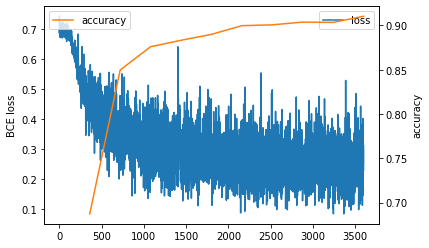

In [ ]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))



plt.plot(avg_train_loss, label="train loss")
plt.plot(avg_eval_loss, label="test loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, avg_train_acc, label="train accuracy", c="C1")
plt.plot(xs, avg_eval_acc, label="test accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

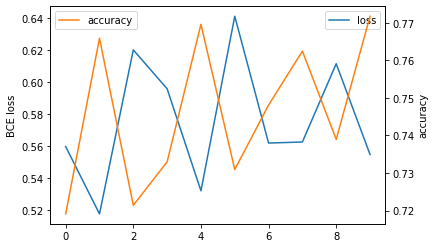

In [ ]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()